In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../../../plotMithraPy')
import plotMiFuncs as pmf
import numpy as np
# To make plot backgrounds white
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"
import matplotlib.pyplot as plt
import pandas as pd
import os 
sys.path.append('/home/arnau/documents/ETHZ/Semester_Project_Master_Thesis/pyOPALTools')
from opal.parser.H5Parser import H5Parser
from decimal import Decimal
from scipy.signal import find_peaks

########################
for_report = False
generic_fn = '/und'
fs = 14
########################

params = pd.read_csv('cases.txt', sep = ' ', comment = '#')
print(params.shape)

def strParam(row):
    text = ''
    text += row['case'] + '\n'  # REMOVE
    g0 = row['E'] * 1e-6 / .511 / np.sqrt(1 + .5 * 10.81**2)
    lr = 85e-3 / 2 / g0**2
    if row['solver'] == 'FW':
        text += 'Wiggler'
    else:
        text += 'Drift'
    text += '\n$\lambda/c = $' + str(row['lam']*1e12) + 'ps, $\lambda = $' + str(row['lam']*3e8*1e6) + '$\mu$m\n$\sigma_r = $' + str(int(row['sigr']*1e6)) + '$\mu$m\n $E = $' + str(row['E']*1e-6) + 'MeV'
    if row['E'] > 30e6:
        text += ', $\lambda_r = $' + str(int(lr*1e6)) + '$\mu$m'
    return text

if not for_report:
    from datetime import date
    today = date.today()
    footnote = 'A.Albà, ' + str(today) + '\ndir: /' + (os.path.split(os.getcwd()))[1]
else:
    footnote = " "

pltpath = 'plots'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(39, 5)


# Functions

In [3]:
def reduceX(x, redF):
    d = []
    for i in range(len(x)):
        if np.random.rand() > 1 / redF:
            d.append(i)
    x = np.delete(x, d)
    return [x,d]

def get_screen_xy( fn_prefix, screen_name, qx, qy, show = False, reduce_factor = 1 ):    
    ''' 
    Get data to plot from file fn and given screen. qx and qy are arrays of strings with data to plot
    eg ['z'], ['x', 'E'] 
    '''
    fn = fn_prefix + screen_name
    h5p = H5Parser()
    step = 0
    h5p.parse( fn, False )
    if show:
        print(h5p)
    if qx == 't':
        qx = 'time'
    if qy == 't':
        qy = 'time'

    x = h5p.getStepDataset( dsetName = qx, step = step)
    ogN = len(x)
    [x,delInd] = reduceX(x,reduce_factor)
    print(ogN, 'particles has been reduced to', len(x))
    if qy == 'E':
        # Get E
        E = []
        px = h5p.getStepDataset( dsetName = 'px', step = step)
        px = np.delete(px,delInd)
        py = h5p.getStepDataset( dsetName = 'py', step = step)
        py = np.delete(py,delInd)
        pz = h5p.getStepDataset( dsetName = 'pz', step = step)
        pz = np.delete(pz,delInd)
        for i, pxi in enumerate(px):
            p2 = px[i]**2 + py[i]**2 + pz[i]**2  
            E.append( np.sqrt( 1 + p2 )*.511 )
        y = np.array(E) * 1e6
    else:
        y = h5p.getStepDataset( dsetName = qy, step = step)
        y = np.delete(y,delInd)
            
    spos = h5p.getStepAttribute('SPOS', step = step)
    print('spos = ',spos)

    
    return [ np.array(x), np.array(y), spos[0] ]


def FT( x, y, cut = [], nbins = 100, boolplot = False, prominence = 0.0 ):
    [x, y] = cutoff( x, y, cut )
    # Set y data to average 0
    y -= np.average(y)
    # Get data organised in bins
    x_bins = np.linspace( np.min(x), np.max(x), nbins )
    digitized = np.digitize( x, x_bins ) - 1 
    y = np.array(y)
    y_means = [ y[digitized == i].mean() for i in range(nbins) ]
    # Plot
    if boolplot:
        fig, ax = plt.subplots(1,2)
        fig.set_size_inches(15, 5)
        ax[0].scatter( x_bins, y_means, marker = '.', color = 'k' )
        ax[0].grid()
        ax[0].tick_params( axis = 'both', labelsize = fs)
        if len(cut) != 0:
            ax[0].set_xlim( left = cut[0], right = cut[1]  )
    # Fourier transform        
    dist = np.max(x) - np.min(x)
    amp = np.fft.fft(y_means)[:nbins//2] / nbins
    freq = np.arange( nbins//2 ) / dist
    # Find peak frequencies
    peaks, _ = find_peaks( np.abs(amp), prominence = prominence )
    amp_peaks = np.abs(amp)[peaks]
    peaks = peaks / dist
    if boolplot:
        for peak in peaks:
            ax[1].axvline( peak, color = 'r' )
        ax[1].plot( freq, np.abs(amp) )
        ax[1].grid()
        ax[1].tick_params( axis = 'both', labelsize = fs)
        ax[1].set_xlabel('freq [$m^-1$]')
        print('peaks at ', peaks)
    
    return [ freq, amp, peaks, amp_peaks ]

def adjust_axes_limits( axs, axis = 'x' ):
    '''
    Adjusts all axis ranges to the one with the biggest range
    axs : (list or array af matplotlib axes)
    axis : (string) Indicates whether to adjust x or y axis
    '''
    crange = []
    for ax in axs:
        if axis == 'x':
            crange.append( np.ptp(ax.get_xlim()) )
        elif axis == 'y':
            crange.append( np.ptp(ax.get_ylim()) )

    def change_limits( ax, r, axis = 'x' ):
        if axis == 'x':
            ax.set_xlim( ax.get_xlim()[0] - r/2., ax.get_xlim()[1] + r/2.)
        elif axis == 'y':
            ax.set_ylim( ax.get_ylim()[0] - r/2., ax.get_ylim()[1] + r/2.)

    r = np.max(crange)
    for i, ax in enumerate(axs):
        change_limits( ax, r - crange[i], axis = axis  )

In [4]:
def getStats(fn, show = False):
    print(fn)
    text = open( fn, 'r' )
    names = []
    units = []
    for line in text:
        if 'name' in line:
            ind1 = line.find('=')
            ind2 = line.find(',')
            name = line[ind1+1:ind2]
        if 'units' in line:
            ind1 = line.find('=')
            ind2 = line.find(',')
            unit = line[ind1+1:ind2]
            if unit == '1':
                unit = ' '
            names.append( name )
            units.append( unit )
    if show:
        for i, n in enumerate(names):        
            print( i, n, ' [', units[i], ']' )
    stat = pd.read_csv( filepath_or_buffer = fn,
                        skiprows = 279, sep = '\s+', names = names)
    return[stat, names, units]

# Plot stats

In [ ]:
fn = 'tests/' + params['case'][9] + generic_fn + '.stat'
[stat, names, units] = getStats(fn, show = False)

tests/dr_case2/und.stat


value of dE [MeV] at [25.8] are [0.12275584]
value of rms_x [m] at [25.8] is [0.00276533]


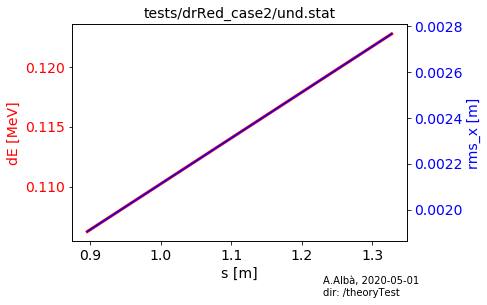

In [8]:
################################
xax = 1
ylax = 39
yrax = 5  # -1 to plot only one quantity
colorL = 'r'
colorR = 'b'
getValuesAt = [25.8]
################################
x = np.array( stat[names[xax]] )
labxax = str( names[xax] + ' [' + units[xax] + ']')

y = np.array( stat[names[ylax]] )
labyax = str( names[ylax] + ' [' + units[ylax] + ']')
# if 'emit' in labyax:
#     y = np.log(y)
#     labyax = 'log ' + labyax

fig, ax1 = plt.subplots()
if 'emit' in labyax:
    ax1.semilogy(x, y, color = colorL, lw = 2)
else:
    ax1.plot( x, y, color = colorL, lw = 3 )
# ax1.plot( x, np.array(stat[names[ylax+1]]), color = 'k' )
# ax1.legend(['rms_x', 'rms_y'], fontsize = fs)
ax1.set_xlabel(labxax, fontsize = fs)
ax1.set_ylabel(labyax, fontsize = fs, color = colorL)
ax1.tick_params( axis = 'y', labelsize = fs, labelcolor = colorL )
ax1.tick_params( axis = 'x', labelsize = fs, labelcolor = 'k')
if len(getValuesAt) > 0:
    print( 'value of', labyax, 'at', getValuesAt, 'are', np.interp(getValuesAt, x, y) )


plt.text( .75, -.25, footnote, transform=ax1.transAxes )
plt.title(fn, fontsize = fs)
# ax1.grid()
# ax1.set_xlim( left = 0.0, right = 2 )
# ax1.set_ylim( bottom = 0.0, top = 14e-3 )

if yrax != -1:
    y = np.array( stat[names[yrax]] )
    labyax = str( names[yrax] + ' [' + units[yrax] + ']')
    if 'emit' in labyax:
        y = np.log(y)
        labyax = 'log ' + labyax
    ax2 = ax1.twinx()
    ax2.plot( x, y, color = colorR )
    ax2.set_ylabel(labyax, fontsize = fs, color = colorR)
    ax2.tick_params( axis = 'y', labelsize = fs, labelcolor = colorR )
    # ax2.set_ylim( bottom = .0, top = .04 )
    # ax2.grid()
    if len(getValuesAt) > 0:
        print( 'value of', labyax, 'at', getValuesAt, 'is', np.interp(getValuesAt, x, y) )
        # ax1.axvline(getValuesAt[0])

# ax1.annotate('$\epsilon_x = 7.45$ mm mrad', xy = (25.8, 7.45e-6),
#              xytext = (12,1e-4), arrowprops=dict(facecolor='black', shrink=1e-9), fontsize = fs)
# ax2.annotate('$\sigma_x = 1.25$ mm', xy = (25.8, 1.25e-3),
#              xytext = (12,3.25e-3), arrowprops=dict(facecolor='black', shrink=1e-9), fontsize = fs)
plt.savefig('plots/rms_6cavs.png', bbox_inches='tight')
plt.show()

tests/dr_case0/und.stat
end y value =  0.04879281188482367
tests/drRed_case0/und.stat
end y value =  0.1601242711198365
tests/dr_case1/und.stat
end y value =  0.03655597101921237
tests/drRed_case1/und.stat
end y value =  0.1543375610575406
tests/dr_case1andahalf/und.stat
end y value =  0.02985549056917567
tests/drRed_case1andahalf/und.stat
end y value =  0.145643906639121
tests/dr_case2/und.stat
end y value =  0.0207380466090564
tests/drRed_case2/und.stat
end y value =  0.122755835018042
tests/dr_case3/und.stat
end y value =  0.061972053455973626
tests/drRed_case3/und.stat
end y value =  0.1405730111610839
tests/dr_case5/und.stat
end y value =  0.02587258018809966
tests/drRed_case5/und.stat
end y value =  0.07687809656151709
tests/dr_case11/und.stat
end y value =  0.01623961401417738
tests/drRed_case11/und.stat
end y value =  0.08712536648532174


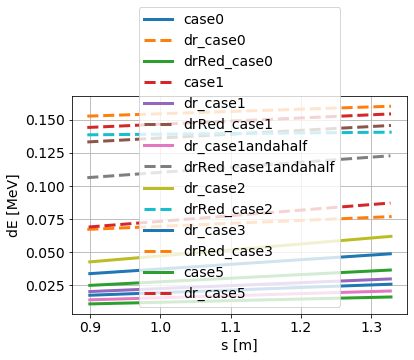

In [10]:
xax = 1
yax = 39
fig, ax = plt.subplots()

for i,row in params.iterrows():
    pref = 'tests/' + row['case']
    if not 'dr' in pref:
        continue
    [stat, names, units] = getStats(pref + generic_fn + '.stat', show = False)
    x = np.array( stat[names[xax]] )
    labxax = str( names[xax] + ' [' + units[xax] + ']')
    y = np.array( stat[names[yax]] )
    labyax = str( names[yax] + ' [' + units[yax] + ']')
    if 'Red' in pref:
        ax.plot( x, y, lw = 3, ls = '--' )
    else:
        ax.plot( x, y, lw = 3 )
    print('end y value = ', y[-1])

ax.set_xlabel(labxax, fontsize = fs)
ax.set_ylabel(labyax, fontsize = fs)
ax.tick_params( axis = 'both', labelsize = fs)
ax.legend(params['case'], fontsize = fs)

ax.grid()

plt.savefig('plots/all_dE.png', bbox_inches='tight')
plt.show()
    

In [5]:
print(params)

                   case           lam      sigr           E  solver
0                 case0  4.000000e-13  0.000340  44000000.0      FW
1              dr_case0  4.000000e-13  0.000340  44000000.0  static
2           drRed_case0  4.000000e-13  0.000340   5700000.0  static
3                 case1  4.000000e-13  0.000681  44000000.0      FW
4           case1LowRes  4.000000e-13  0.000681  44000000.0      FW
5   case1LowResInjected  4.000000e-13  0.000681  44000000.0      FW
6            case1VLRes  4.000000e-13  0.000681  44000000.0      FW
7              dr_case1  4.000000e-13  0.000681  44000000.0  static
8           drRed_case1  4.000000e-13  0.000681   5700000.0  static
9                 case2  4.000000e-13  0.001800  44000000.0      FW
10             dr_case2  4.000000e-13  0.001800  44000000.0  static
11          drRed_case2  4.000000e-13  0.001800   5700000.0  static
12                case3  2.000000e-12  0.000340  44000000.0      FW
13             dr_case3  2.000000e-12  0.000340 

Plotting tests/case6


29999988 particles has been reduced to 2997113


Plotting tests/dr_case6


500000 particles has been reduced to 50096


spos =  [1.13]


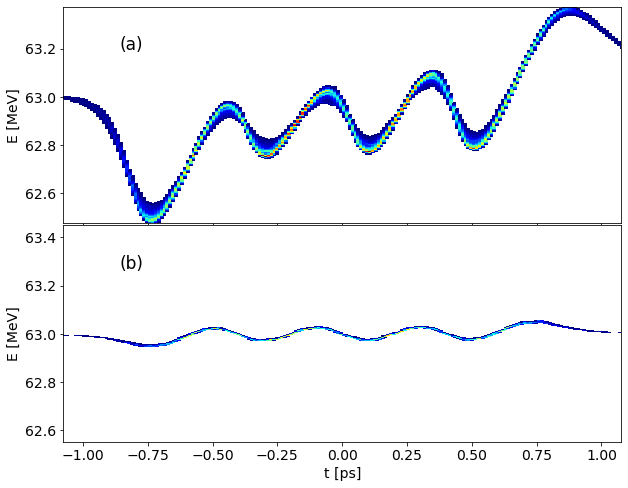

In [15]:
# All energies
fileStatic = '/SCREEN.h5'
fileFW  ='/bunch-screen/bunch-p#-screen#.txt'
qx = 't'
qy = 'E'
paramsLocal = params
paramsLocal = paramsLocal.drop([0,1,2,3,4,5,6,7,8,9,10,11,
                                12,13,14,15,16,17,18,19,20,
                                23,24,25,26,27,28,29,
                                30,31,32,33,34,35,36,37,38] )
# paramsLocal = paramsLocal.drop([4,5,6])
# paramsLocal = paramsLocal.drop(np.append([0,1,4,5,6,7], np.arange(9,38)))
saveFN = 'paperComparisonCase6.png'


fig, ax = plt.subplots(paramsLocal.shape[0], sharex = True, figsize = (10, 4*paramsLocal.shape[0]))
fig.subplots_adjust(hspace = .01)
i = 0
for _,row in paramsLocal.iterrows():
    fn = 'tests/' + row['case']
    print('Plotting', fn)
    if 'dr' in row['case']:
        [x,y,spos] = get_screen_xy(fn, fileStatic, qx, qy, show = False, reduce_factor = 10)
    else:
        [x,y] = pmf.importScreenXY( fn + fileFW, show = False, xquant = qx, yquant = qy, index_screen = -1, reduce_factor = 10, sliceT = [] )
    pmf.plotScreenXY(ax[i], x, y, [qx, qy], type = 'hist2d', factors = [-1e12,1e-6], nbins = 200, color = 1, maxHH = .2)
    # ax[i].text( 1.25, .5, strParam(row), fontsize = fs, transform = ax[i].transAxes  )
    # ax[i].grid()
    # if row['E'] > 50e6:
    #     ax[i].set_ylim(bottom = 62.4, top = 63.4)
    # else:
    #     ax[i].set_ylim(bottom = 43.3, top = 44.5)
    ax[i].set_xlabel('')
    i += 1
pmf.adjust_axes_limits(ax, 'x')
pmf.adjust_axes_limits(ax, 'y')
ax[-1].set_xlabel('t [ps]', fontsize = fs)
ax[0].text( .1, .8, '(a)', fontsize = fs+3, transform = ax[0].transAxes  )
ax[1].text( .1, .8, '(b)', fontsize = fs+3, transform = ax[1].transAxes  )

plt.savefig((pltpath + '/' + saveFN),bbox_inches='tight')


tests/case1LowRes/bunch-sampling/bunch.txt
tests/case1LowResInjected/bunch-sampling/bunch.txt


Mesh limits z -0.06397111208099035 0.06397111208099035
Mesh limits x -0.01 0.01
Mesh limits y -0.01 0.01


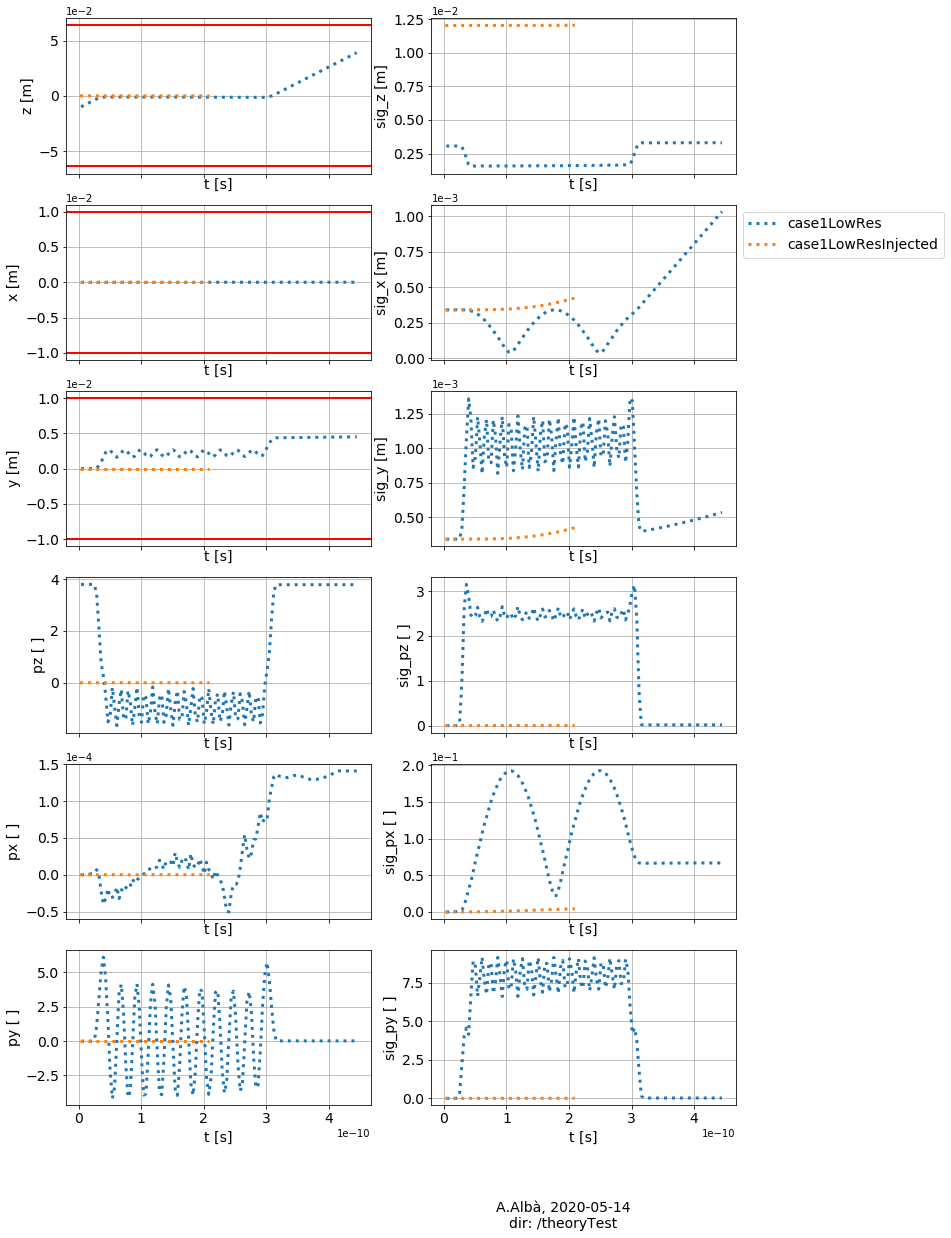

In [90]:
# Stats undulator
paramsLocal = params
paramsLocal = paramsLocal.drop(np.arange(6,38))
paramsLocal = paramsLocal.drop([0,3])

stats = []
leg = []
for _,row in paramsLocal.iterrows():
    p = 'tests/' + row['case']
    if 'dr' in p:
        continue
    leg.append(row['case'])
    stats.append( pmf.importStat( p + '/bunch-sampling/bunch.txt', show = True) )

names = [ 'z', 'sig_z', 'x', 'sig_x', 'y', 'sig_y',
          'pz', 'sig_pz', 'px', 'sig_px', 'py', 'sig_py']

fig, axs = plt.subplots( 6,2, figsize = ( 12, 20 ), sharex = True )
Ls = [20e-3, 20e-3, 8e-3]  # Mesh lengths
K = 10.81
E = 63  # MeV
Ls[2] *= E / .511 / np.sqrt(1 + .5 * K**2)  # * gamma_
dotted = [0,1,2,3,4,5]  # Indexes from fnames to plot with dotted lines
notPlot = []  # Indexes from fnames not to plot
legLocal = []
for i, ax in enumerate(axs.reshape(-1)):
    ax.grid()
    for j, stat in enumerate(stats):
        if j in notPlot:
            continue
        if j in dotted:
            ls = ':'
            lw = 3
        else:
            ls = '-'
            lw = 2
        pmf.plotStat(ax, stat, quants = ['t',names[i]], factors = [1, 1], fs = fs, lw = lw, ls = ls )
        # legLocal.append(leg[j])
        # if int(i/10) == 0:
        #     ax.set_xlabel('')
        axs[1,1].legend(leg, fontsize = fs, bbox_to_anchor = [1., 1.])
# Draw mesh limits
xyz = ['x', 'y', 'z']
for j in range(3):
    i  = (2 + j) % 3
    print('Mesh limits', xyz[i], -.5 * Ls[i], .5 * Ls[i])
    axs[j,0].axhline(-.5 * Ls[i], lw = 2, color = 'r')
    axs[j,0].axhline(.5 * Ls[i], lw = 2, color = 'r')
    # axs[j,0].set_ylim(bottom = -.5 * Ls[i], top = .5 * Ls[i])  # Mesh limits as plot limits
if not for_report:
    fig.text(.7, .04, footnote, fontsize = fs, ha='center')
# plt.savefig((pltpath + '/avg.png'),bbox_inches='tight')
plt.show()

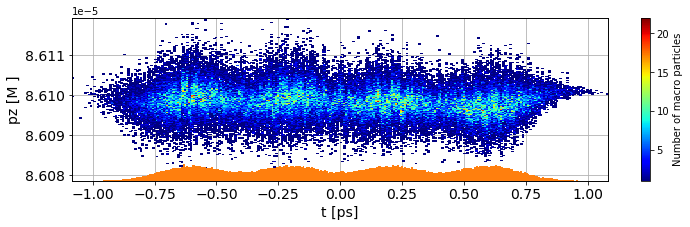

In [59]:
qx = 't'
qy = 'pz'

fig, ax = plt.subplots(figsize = (12,3))
[x,y] = pmf.importScreenXY( 'tests/case1LowRes/bunch-screen/bunch-p#-screen#.txt', show = False, xquant = qx, yquant = qy, index_screen = 0, reduce_factor = 1, sliceT = [])
pmf.plotScreenXY(ax, x, y, [qx, qy], type = 'hist2d-hist', factors = [-1e12,1e-6], nbins = 300, color = 1, maxHH = .1)
ax.grid()
plt.savefig((pltpath + '/initCurrent.png'),bbox_inches='tight')
plt.show()


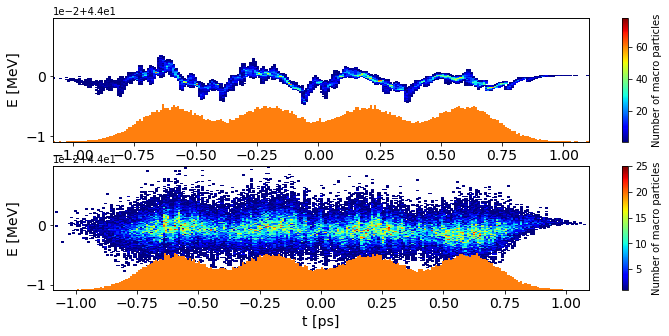

In [129]:
qx = 't'
qy = 'E'
idx_scr = 0

fig, ax = plt.subplots(2, figsize = (12,5), sharex = False)
[x,y] = pmf.importScreenXY( 'tests/case1ExtremelyLowRes/bunch-screen/bunch-p#-screen#.txt', show = False, xquant = qx, yquant = qy, index_screen = idx_scr, reduce_factor = 1)
pmf.plotScreenXY(ax[0], x, y, [qx, qy], type = 'hist2d-hist', factors = [-1e12,1e-6], nbins = 250, color = 1, maxHH = .3)

[x,y] = pmf.importScreenXY( 'tests/case1LowRes/bunch-screen/bunch-p#-screen#.txt', show = False, xquant = qx, yquant = qy, index_screen = idx_scr, reduce_factor = 1)
pmf.plotScreenXY(ax[1], x, y, [qx, qy], type = 'hist2d-hist', factors = [-1e12,1e-6], nbins = 250, color = 1, maxHH = .3)

pmf.adjust_axes_limits(ax, 'x')
pmf.adjust_axes_limits(ax, 'y')
plt.show()


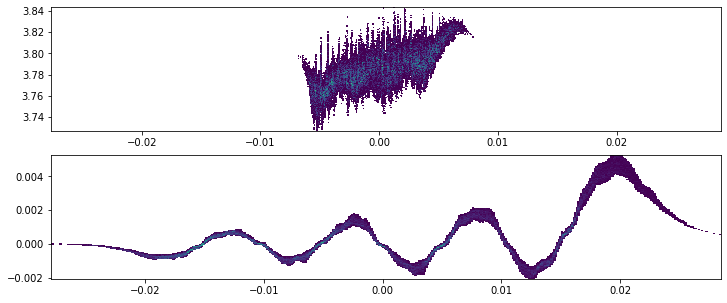

In [95]:
qx = 'z'
qy = 'pz'
nump = 16
reduce_factor = 1

x = []
y = []
sname = 'tests/case1LowRes/bunch-profile/bunch-p#-2944.txt'
posp = sname.find('#')
for p in range(nump):
    pname = sname[:posp] + str(p) + sname[posp+1:]
    # print('Reading', pname)
    df = pd.read_csv(pname, sep='\t', header = None, names = ['q', 'x', 'y', 'z', 'px', 'py', 'pz'])
    df = df.reset_index()
    if reduce_factor > 1:
        d = []
        for i in range(df.shape[0]):
            if np.random.rand() > 1 / reduce_factor:
                d.append(i)
        df = df.drop(d)
    # if df.shape[0] != 0:
    #     print('processor', p, ', range = ', np.max(df[qx]) -np.min(df[qx]))
    x = np.append(x,np.array(df[qx]))
    y = np.append(y,np.array(df[qy]))

x2 = []
y2 = []
sname = 'tests/case1LowResInjected/bunch-profile/bunch-p#-162.txt'
posp = sname.find('#')
for p in range(nump):
    pname = sname[:posp] + str(p) + sname[posp+1:]
    # print('Reading', pname)
    df = pd.read_csv(pname, sep='\t', header = None, names = ['q', 'x', 'y', 'z', 'px', 'py', 'pz'])
    df = df.reset_index()
    if reduce_factor > 1:
        d = []
        for i in range(df.shape[0]):
            if np.random.rand() > 1 / reduce_factor:
                d.append(i)
        df = df.drop(d)
    # if df.shape[0] != 0:
    #     print('processor', p, ', range = ', np.max(df[qx]) -np.min(df[qx]))
    x2 = np.append(x2,np.array(df[qx]))
    y2 = np.append(y2,np.array(df[qy]))


fig, ax = plt.subplots(2,figsize = (12,5))
ax[0].hist2d(x-x.mean(), y, bins = 450, cmin = 1)
ax[1].hist2d(x2-x2.mean(), y2, bins = 450, cmin = 1)
pmf.adjust_axes_limits(ax, 'x')
# pmf.adjust_axes_limits(ax, 'y')
# ax[0].set_xlim(left = 0, right = 2)
plt.show()


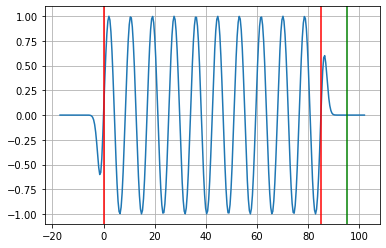

In [54]:
nl = 10
lam = 8.5
k = 2 * np.pi / lam
x = np.linspace(-2*lam, lam*(nl+2), 300)
y = np.zeros(len(x))
for i,_ in enumerate(x):
    if x[i] > 0 and x[i] < lam*nl:
        y[i] = np.sin(k * x[i])
    elif x[i] <= 0:
        y[i] = k * x[i] * np.exp(- k**2 * x[i]**2 /2)
    elif x[i] >= nl * lam:
        xloc = x[i] - nl * lam
        y[i] = k * xloc * np.exp(- k**2 * xloc**2 /2)

plt.plot(x,y)
plt.axvline(0, color = 'r')
plt.axvline(nl*lam, color = 'r')
plt.axvline(95, color = 'g')
plt.grid()
plt.show()

['case0' 'case1' 'case1LowRes' 'case1LowResInjected' 'case1VLRes' 'case2'
 'case6' 'case7' 'case8' 'drRed_case0' 'drRed_case1' 'drRed_case2'
 'drRed_case3' 'drRed_case4' 'drRed_case6' 'drRed_case7' 'drRed_case8'
 'dr_case0' 'dr_case1' 'dr_case2' 'dr_case6' 'dr_case7' 'dr_case8']


Plotting tests/case0
skipping...
Plotting tests/dr_case0
skipping...
Plotting tests/drRed_case0
skipping...
Plotting tests/case1
skipping...
Plotting tests/case1LowRes
skipping...
Plotting tests/case1LowResInjected
skipping...
Plotting tests/case1VLRes
skipping...
Plotting tests/dr_case1
skipping...
Plotting tests/drRed_case1
skipping...
Plotting tests/case2
skipping...
Plotting tests/dr_case2
skipping...
Plotting tests/drRed_case2
skipping...
Plotting tests/case3


29999962 particles has been reduced to 3001157


Plotting tests/dr_case3


500000 particles has been reduced to 50210


spos =  [1.13]
Plotting tests/drRed_case3
skipping...
Plotting tests/case4


29999962 particles has been reduced to 3000272


Plotting tests/dr_case4


500000 particles has been reduced to 50027


spos =  [1.13]
Plotting tests/drRed_case4
skipping...
Plotting tests/case5


2999978 particles has been reduced to 299253
Plotting tests/dr_case5


500000 particles has been reduced to 49932


spos =  [1.13]
Plotting tests/drRed_case5


500000 particles has been reduced to 50451


spos =  [1.13]
Plotting tests/case6
skipping...
Plotting tests/dr_case6
skipping...
Plotting tests/drRed_case6
skipping...
Plotting tests/case7
skipping...
Plotting tests/dr_case7
skipping...
Plotting tests/drRed_case7
skipping...
Plotting tests/case8
skipping...
Plotting tests/dr_case8
skipping...
Plotting tests/drRed_case8
skipping...
Plotting tests/case9


29999972 particles has been reduced to 3001026


Plotting tests/dr_case9


500000 particles has been reduced to 49891


spos =  [1.13]
Plotting tests/drRed_case9


500000 particles has been reduced to 49826


spos =  [1.13]
Plotting tests/case10


2999979 particles has been reduced to 300029
Plotting tests/dr_case10


500000 particles has been reduced to 49902


spos =  [1.13]
Plotting tests/drRed_case10


500000 particles has been reduced to 49910


spos =  [1.13]
Plotting tests/case11


2999979 particles has been reduced to 300076
Plotting tests/dr_case11


500000 particles has been reduced to 49812


spos =  [1.13]
Plotting tests/drRed_case11


500000 particles has been reduced to 49802


spos =  [1.13]


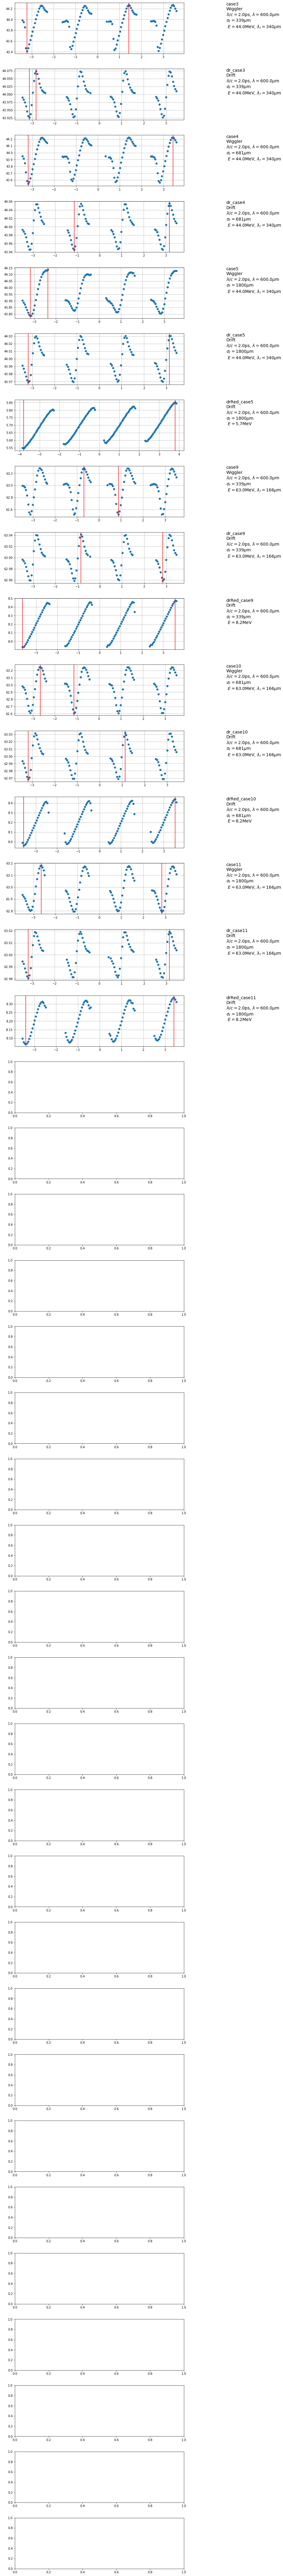

In [78]:
# Get dE for each example
fileStatic = '/SCREEN.h5'
fileFW  ='/bunch-screen/bunch-p#-screen#.txt'
qx = 't'
qy = 'E'
dt = .05  # In picoseconds
paramsLocal = params
# paramsLocal = paramsLocal.drop([4,5,6])
# paramsLocal = paramsLocal.drop( )
saveFN = 'modAll.png'
infoFn = 'minMaxParams.tsv'
done = pd.read_csv(infoFn, sep = ' ', comment = '#')
done = np.array(done['case'])
print(done)
file = open( infoFn, mode = 'a' )

fig, ax = plt.subplots(paramsLocal.shape[0], sharex = False, figsize = (10, 4*paramsLocal.shape[0]))
fig.subplots_adjust(hspace = .3)
i = 0
for _,row in paramsLocal.iterrows():
    fn = 'tests/' + row['case']
    print('Plotting', fn)
    if row['case'] in done:
        print('skipping...')
        continue
    if 'dr' in row['case']:
        [x,y,spos] = get_screen_xy(fn, fileStatic, qx, qy, show = False, reduce_factor = 10)
    else:
        [x,y] = pmf.importScreenXY( fn + fileFW, show = False, xquant = qx, yquant = qy, index_screen = -1, reduce_factor = 10, sliceT = [] )
    x -= x.mean()
    x *= -1e12
    y *= 1e-6
    nbins = (np.max(x) - np.min(x)) / dt
    bin_edges = np.linspace( np.min(x), np.max(x), nbins )
    nbins = len(bin_edges) - 1
    bin_size = bin_edges[1] - bin_edges[0]
    digitized = np.digitize( x, bin_edges )  # Get data organised in bins
    bin_means = np.zeros(nbins)
    bin_stds = np.zeros(nbins)
    for j in range(nbins):
        if len(y[digitized == j+1]) > 0:
            bin_means[j] = y[digitized == j+1].mean()
            bin_stds[j] = y[digitized == j+1].std()
        else:
            bin_means[j] = np.NaN
            bin_stds[j] = np.NaN
    x = bin_edges[1:] - .5*bin_size
    # slope = (bin_means[-1] - bin_means[0]) / (x[-1] - x[0])
    # flaty = [bin_means[j] - slope * (x[j] - x[0]) for j in range(nbins)]
    flaty = bin_means
    ax[i].plot(x, bin_means, lw = 0, marker = 'o')
    # ax[i].plot(x, flaty, lw = 3)
    # indpeaks,_ = find_peaks(flaty)
    # if len(indpeaks) > 0:
    #     ind1 = (np.abs(x[indpeaks] - 0.0)).argmin()
    #     ind1 = indpeaks[ind1]
    #     indpeaks,_ = find_peaks(-bin_means[:ind1])
    #     if len(indpeaks) > 0:
    #         ind2 = (np.abs(x[indpeaks] - x[ind1])).argmin()
    #         ind2 =indpeaks[ind2]
    #         ax[i].axvline( x[ind1], color = 'r' )
    #         ax[i].axvline( x[ind2], color = 'r' )
    #         dE = bin_means[ind1] - bin_means[ind2]
    #         err = bin_stds[ind1] + bin_stds[ind2]
    #     else:
    #         dE = 0
    #         err = bin_stds[nbins//2]
    # else:
    #     dE = 0
    #     err = bin_stds[nbins//2]
    # MANUAL
    # if 'case2' in row['case']:
    #     ind1 = .4
    #     ind2 = 0.0
    # elif 'case3' in row['case']:
    #     ind1 = 4.5
    #     ind2 = -4.5
    # elif 'case9' in row['case']:
    #     ind1 = 1.5
    #     ind2 = 0.4
    dind = np.isnan(bin_means)
    x = x[~dind]
    bin_means = bin_means[~dind]
    bin_stds = bin_stds[~dind]
    ind1 = (bin_means).argmax()
    ind2 = (bin_means).argmin()
    ax[i].axvline( x[ind1], color = 'r' )
    ax[i].axvline( x[ind2], color = 'r' )
    dE = bin_means[ind1] - bin_means[ind2]
    err = bin_stds[ind1] + bin_stds[ind2]
    file.write(row['case'] + ' ' + str(dE) + ' ' + str(err) + '\n' )
    ax[i].text( 1.25, .5, strParam(row), fontsize = fs, transform = ax[i].transAxes  )
    ax[i].grid()
    i += 1
    
file.close()
# pmf.adjust_axes_limits(ax, 'x')
# pmf.adjust_axes_limits(ax, 'y')

plt.savefig((pltpath + '/' + saveFN),bbox_inches='tight')

case0
case1
case2
case3
case4
case5
case6
case7
case8
case9
case10
case11
drRed_case0
drRed_case1
drRed_case2
drRed_case3
drRed_case4
drRed_case5
drRed_case6
drRed_case7
drRed_case8
drRed_case9
drRed_case10
drRed_case11
dr_case0
dr_case1
dr_case2
dr_case3
dr_case4
dr_case5
dr_case6
dr_case7
dr_case8
dr_case9
dr_case10
dr_case11
12 12 12 12 12 12


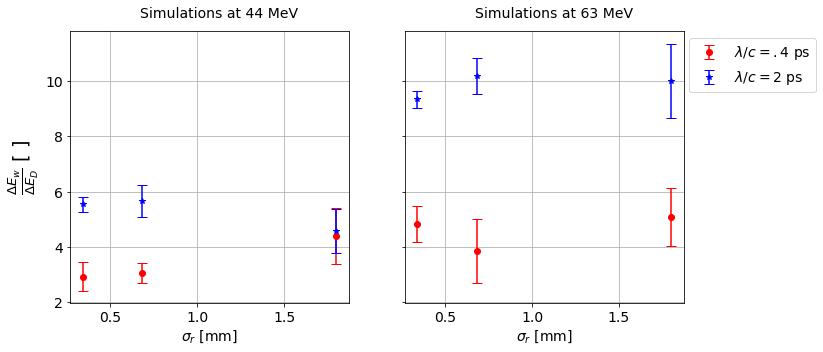

In [13]:
df = pd.read_csv('sliceParams.tsv', sep = ' ', comment = '#')
w = np.zeros(0)
werr = np.zeros(0)
d = np.zeros(0)
derr = np.zeros(0)
dr = np.zeros(0)
drerr = np.zeros(0)
for i,row in df.iterrows():
    print(row['case'])
    if 'drRed_' in row['case']:
        dr = np.append(dr, row['dE'])
        drerr = np.append(drerr, row['std'])
        if row['dE'] == 0:
            dr[-1] = drerr[-1]
    elif 'dr_' in row['case']:
        d = np.append(d, row['dE'])
        derr = np.append(derr, row['std'])
    else:
        w = np.append(w, row['dE'])
        werr = np.append(werr, row['std'])

x = np.array([.340 ,.680 ,1.8])
print(len(w), len(werr), len(d), len(derr), len(dr), len(drerr))

fig, ax = plt.subplots(1,2, figsize = (11,5), sharey = True)
ax[0].errorbar(x, w[:3] / d[:3], yerr = werr[:3] / d[:3], fmt = 'o', capsize = 5, color = 'r')
ax[0].errorbar(x, w[3:6] / d[3:6], yerr = werr[3:6] / d[3:6], fmt = '*', capsize = 5, color = 'b')

ax[1].errorbar(x, w[6:9] / d[6:9], yerr = werr[6:9] / d[6:9], fmt = 'o', capsize = 5, color = 'r')
ax[1].errorbar(x, w[9:] / d[9:], yerr = werr[9:] / d[9:], fmt = '*', capsize = 5, color = 'b')

ax[0].tick_params( axis = 'both', labelsize = fs )
ax[0].set_xlabel( r'$\sigma_r$ [mm]', fontsize = fs )
ax[0].text( .25, 1.05, 'Simulations at 44 MeV', fontsize = fs, transform = ax[0].transAxes  )
ax[0].grid()
ax[1].tick_params( axis = 'both', labelsize = fs )
ax[1].set_xlabel( r'$\sigma_r$ [mm]', fontsize = fs )
ax[1].text( .25, 1.05, 'Simulations at 63 MeV', fontsize = fs, transform = ax[1].transAxes  )
ax[1].grid()
ax[0].set_ylabel( r'$\frac{\Delta E_w}{\Delta E_{D}}$ [ ]', fontsize = fs+5 )

# left, bottom, width, height = [0.2, 0.6, 0.25, 0.25]
# ins = fig.add_axes([left, bottom, width, height])
# ins.errorbar(x, w[:3] / dr[:3], yerr = werr[:3] / dr[:3], fmt = 'o', capsize = 5, color = 'r')
# ins.set_ylim(bottom = 18, top = 55 )
# ins.tick_params( axis = 'both', labelsize = fs )

ax[1].legend(['$\lambda/c = .4$ ps', '$\lambda/c = 2$ ps'], fontsize = fs, bbox_to_anchor = [1.5, 1.])
# ax[0].set_ylim(bottom = .8, top = 5)
plt.savefig((pltpath + '/comparison_wiggler_redGamma.png'),bbox_inches='tight')
plt.show()


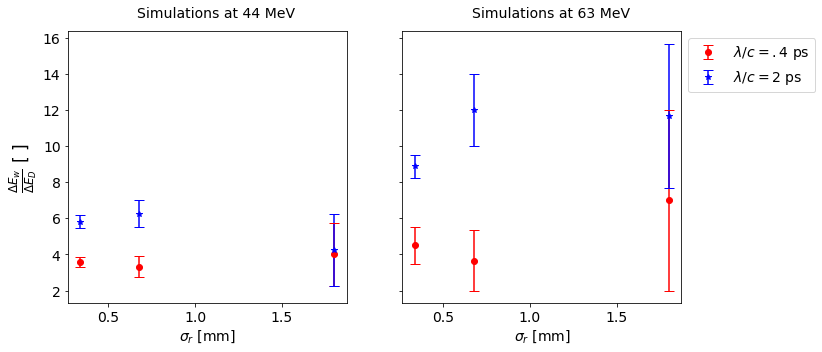

In [13]:
x = np.array([.340 ,.680 ,1.8])
# in cm where 1.5cm = .2 MeV in plots
dE44s = np.array([2.15, 1.5, .8]) 
dE44sErr = np.array([.15, .25, .35]) 
dE44sD = np.array([.6, .45, .2])

# in cm where 1.5cm = .2 MeV in plots
dE44l = np.array([6.4, 5.0, 1.7]) 
dE44lErr = np.array([.4, .6, .8]) 
dE44lD = np.array([1.1, .8, .4])

# in cm where 1.5cm = .2 MeV in plots
dE63s = np.array([1.8, 1.1, .7]) 
dE63sErr = np.array([.4, .5, .5]) 
dE63sD = np.array([.4, .3, .1 ])

# in cm where 1.5cm = .2 MeV in plots
dE63l = np.array([7.1, 6.0, 3.5]) 
dE63lErr = np.array([.5, 1.0, 1.2]) 
dE63lD = np.array([.8, .5, .3])


fig, ax = plt.subplots(1,2, figsize = (11,5), sharey = True)
ax[0].errorbar(x, dE44s / dE44sD, yerr = dE44sErr / dE44sD, fmt = 'o', capsize = 5, color = 'r')
ax[0].errorbar(x, dE44l / dE44lD, yerr = dE44lErr / dE44lD, fmt = '*', capsize = 5, color = 'b')

ax[1].errorbar(x, dE63s / dE63sD, yerr = dE63sErr / dE63sD, fmt = 'o', capsize = 5, color = 'r')
ax[1].errorbar(x, dE63l / dE63lD, yerr = dE63lErr / dE63lD, fmt = '*', capsize = 5, color = 'b')

ax[0].tick_params( axis = 'both', labelsize = fs )
ax[0].set_xlabel( r'$\sigma_r$ [mm]', fontsize = fs )
ax[0].text( .25, 1.05, 'Simulations at 44 MeV', fontsize = fs, transform = ax[0].transAxes  )
ax[1].tick_params( axis = 'both', labelsize = fs )
ax[1].set_xlabel( r'$\sigma_r$ [mm]', fontsize = fs )
ax[1].text( .25, 1.05, 'Simulations at 63 MeV', fontsize = fs, transform = ax[1].transAxes  )
ax[0].set_ylabel( r'$\frac{\Delta E_w}{\Delta E_D}$ [ ]', fontsize = fs+3 )

ax[1].legend(['$\lambda/c = .4$ ps', '$\lambda/c = 2$ ps'], fontsize = fs, bbox_to_anchor = [1., 1.])

plt.savefig((pltpath + '/comparison_fullE_dE.png'),bbox_inches='tight')
plt.show()




12 12 12 12 12 12


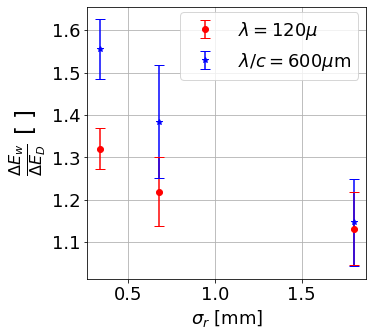

In [22]:
fs = 18
df = pd.read_csv('minMaxParams.tsv', sep = ' ', comment = '#')
w = np.zeros(0)
werr = np.zeros(0)
d = np.zeros(0)
derr = np.zeros(0)
dr = np.zeros(0)
drerr = np.zeros(0)
for i,row in df.iterrows():
#    print(row['case'])
    if 'drRed_' in row['case']:
        dr = np.append(dr, row['dE'])
        drerr = np.append(drerr, row['std'])
        if row['dE'] == 0:
            dr[-1] = drerr[-1]
    elif 'dr_' in row['case']:
        d = np.append(d, row['dE'])
        derr = np.append(derr, row['std'])
    else:
        w = np.append(w, row['dE'])
        werr = np.append(werr, row['std'])

x = np.array([.340 ,.680 ,1.8])
print(len(w), len(werr), len(d), len(derr), len(dr), len(drerr))

fig, ax = plt.subplots(figsize = (5,5))
ax.errorbar(x, w[:3] / dr[:3], yerr = werr[:3] / dr[:3], fmt = 'o', capsize = 5, color = 'r')
ax.errorbar(x, w[3:6] / dr[3:6], yerr = werr[3:6] / dr[3:6], fmt = '*', capsize = 5, color = 'b')

ax.tick_params( axis = 'both', labelsize = fs )
ax.set_xlabel( r'$\sigma_r$ [mm]', fontsize = fs )
ax.grid()
ax.set_ylabel( r'$\frac{\Delta E_w}{\Delta E_{D}}$ [ ]', fontsize = fs+5 )

ax.legend(['$\lambda = 120 \mu$m', '$\lambda/c = 600 \mu$m'], fontsize = fs, bbox_to_anchor = [.3, .7])
# ax.set_ylim(bottom = .8, top = 5)
plt.savefig((pltpath + '/comparison_wiggler_redGamma_forPaper.png'),bbox_inches='tight')
plt.show()
